This project aims to analyze coup events across various countries. The dataset includes information about coups, including the date, type of event (coup, attempted, conspiracy), and various outcomes (e.g., realized, unrealized, injuries, deaths).

### Motivation
understanding the patterns and impacts of coup events can help in analyzing political stability and the factors contributing to successful or failed coups.

### Questions
1. Which countries have experienced the most coup events?
2. How do the types of coup events vary across different countries and time periods?
3. Are there any noticeable patterns or outliers in the data?

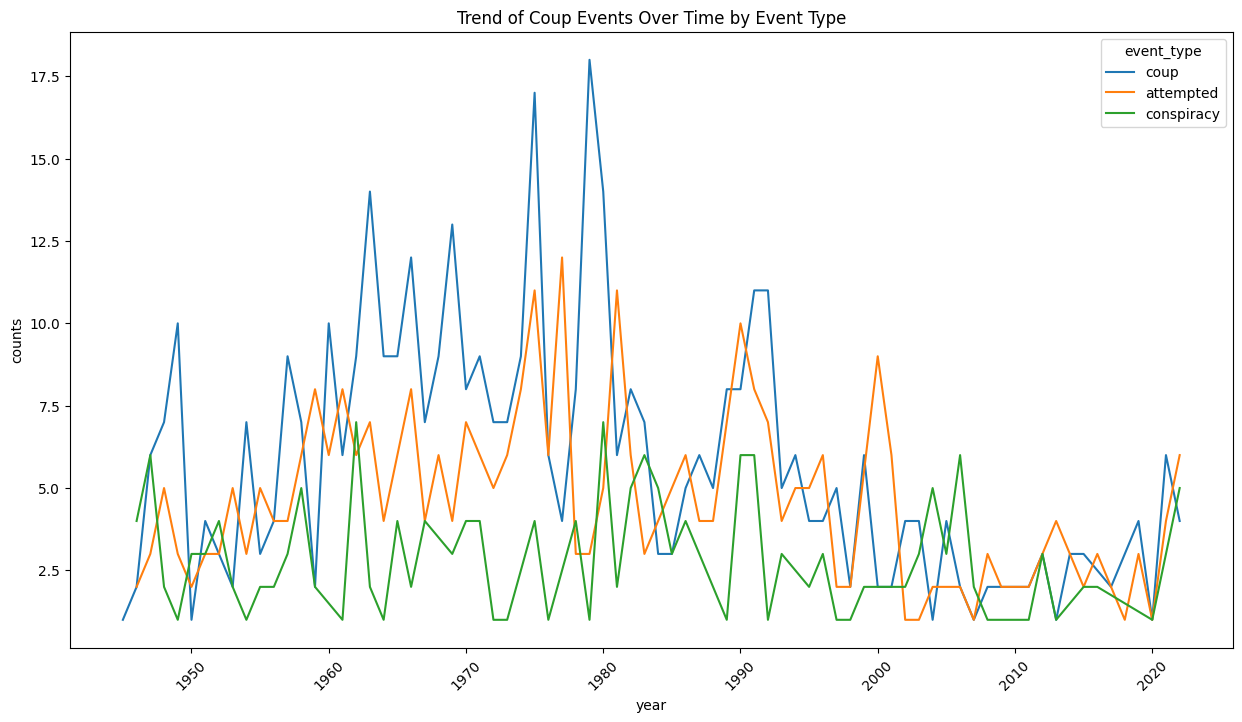

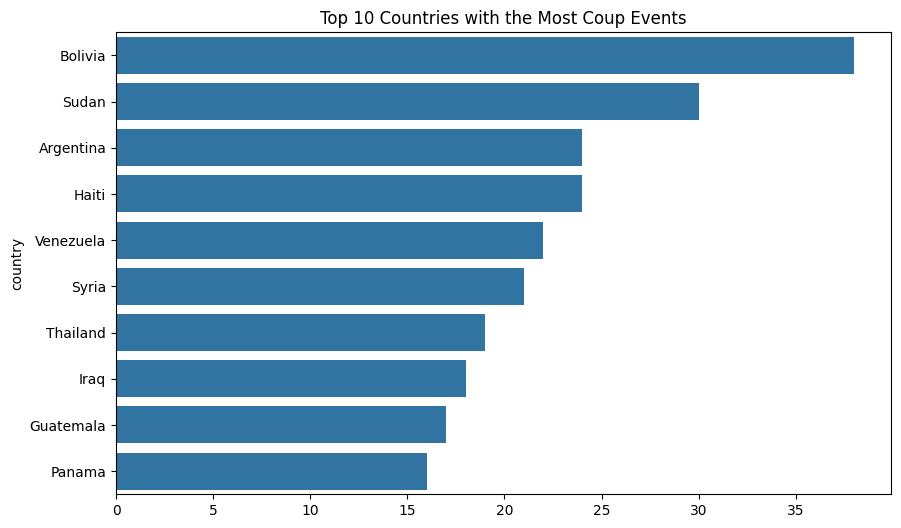

In [8]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('/home/jovyan/DH140-Final-Project/Coup data.csv')
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])



# 2. Trend of coup events over time by event type
plt.figure(figsize=(15, 8))
data['year'] = data['date'].dt.year
event_type_counts = data.groupby(['year', 'event_type']).size().reset_index(name='counts')
sns.lineplot(x='year', y='counts', hue='event_type', data=event_type_counts)
plt.title('Trend of Coup Events Over Time by Event Type')
plt.xticks(rotation=45)
plt.show()


# 4. Top 10 countries with the most coup events
top_countries = data['country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries with the Most Coup Events')
plt.show()

# Preprocessing Data #
1. Dropped Nan Values
2. Group the coup data by country and merge the data with the economic country data
3. Save the merged dataset to a new CSV file
4. Make coup attempts into a binary variable -> predicting whether one will happening in the future

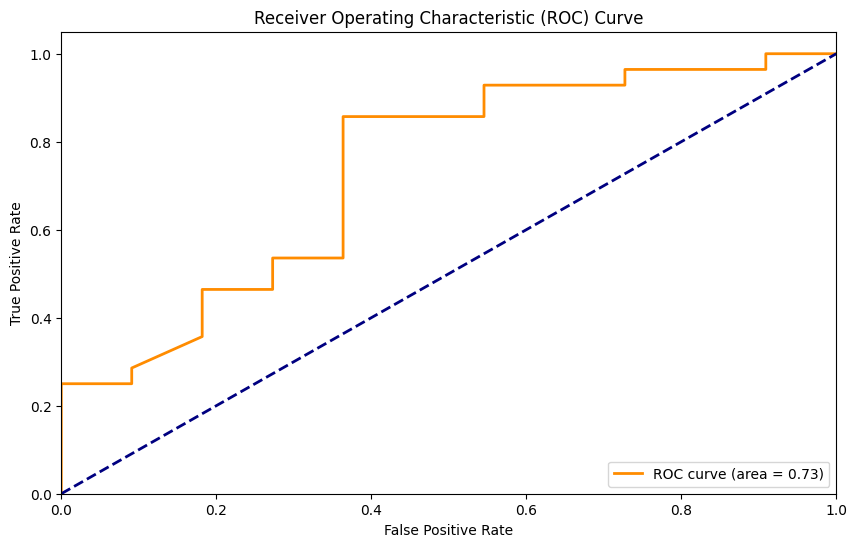

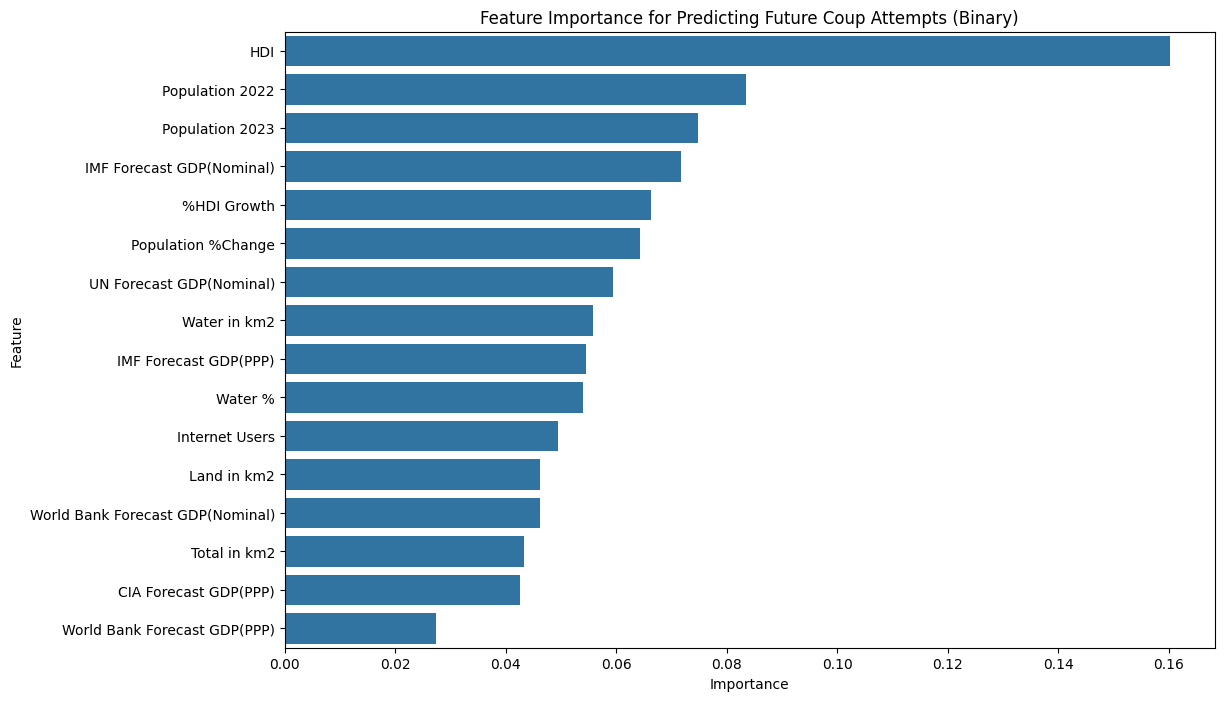

Cross-Validation Accuracy Scores: [0.80769231 0.80769231 0.73076923 0.76923077 0.84      ]
Cross-Validation AUC Scores: [0.82986111 0.86805556 0.69097222 0.63888889 0.85661765]
Average Cross-Validation Accuracy: 0.791076923076923
Average Cross-Validation AUC: 0.7768790849673203
Accuracy: 0.7948717948717948
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.86      0.86      0.86        28

    accuracy                           0.79        39
   macro avg       0.75      0.75      0.75        39
weighted avg       0.79      0.79      0.79        39



In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
coup_data_path = '/home/jovyan/DH140-Final-Project/Coup data.csv'
country_data_path = '/home/jovyan/DH140-Final-Project/Country_data.csv'

coup_data = pd.read_csv(coup_data_path)
country_data = pd.read_csv(country_data_path)

# Remove NaN values from both datasets
coup_data_cleaned = coup_data.dropna()
country_data_cleaned = country_data.dropna()

# Group the coup data by country and summarize the number of each event type
coup_summary = coup_data_cleaned.groupby('country')['event_type'].value_counts().unstack().fillna(0).reset_index()

# Merge the coup summary data with the country data
merged_data = pd.merge(country_data_cleaned, coup_summary, how='left', left_on='Country', right_on='country').drop(columns=['country'])

# Save the merged dataset to a new CSV file
merged_data_path = '/home/jovyan/DH140-Final-Project/Merged_Country_Coup_Data.csv'
merged_data.to_csv(merged_data_path, index=False)

coup_columns = ['attempted', 'conspiracy', 'coup']
for col in coup_columns:
    merged_data[col] = merged_data[col].fillna(0)

# Sum up all coup-related columns into a single 'Coup attempts' column
merged_data['Coup attempts'] = merged_data[coup_columns].sum(axis=1)

# Drop the original coup-related columns
merged_data = merged_data.drop(columns=coup_columns)

# Save the updated merged dataset to a new CSV file
updated_merged_data_path = '/home/jovyan/DH140-Final-Project/Updated_Merged_Country_Coup_Data.csv'
merged_data.to_csv(updated_merged_data_path, index=False)

numeric_data = merged_data.drop(columns=['Country', 'UN Continental Region', 'UN Statistical Subregion']).fillna(0)

# Define the target and features
X = numeric_data.drop(columns=['Coup attempts'])
y = numeric_data['Coup attempts']

merged_data['Coup attempts binary'] = merged_data['Coup attempts'].apply(lambda x: 1 if x > 0 else 0)

# Preprocessing the data for Random Forest model
# Drop non-numeric columns and fill NaN values with 0
numeric_data = merged_data.drop(columns=['Country', 'UN Continental Region', 'UN Statistical Subregion']).fillna(0)

# Define the target and features
X = numeric_data.drop(columns=['Coup attempts', 'Coup attempts binary'])
y = numeric_data['Coup attempts binary']

# Split the data into training and testing sets
_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_accuracy = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
cv_auc = cross_val_score(rf_model, X, y, cv=cv, scoring='roc_auc')

# Predict probabilities for ROC curve
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Get feature importance
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Feature Importance for Predicting Future Coup Attempts (Binary)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the cross-validation accuracy and AUC
cv_accuracy_mean = cv_accuracy.mean()
cv_auc_mean = cv_auc.mean()
# Display the cross-validation accuracy and AUC scores
print("Cross-Validation Accuracy Scores:", cv_accuracy)
print("Cross-Validation AUC Scores:", cv_auc)
print(f'Average Cross-Validation Accuracy: {cv_accuracy.mean()}')
print(f'Average Cross-Validation AUC: {cv_auc.mean()}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)